#                                       Portfolio Optimization & Monte Carlo Simulation

In [32]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import hvplot.pandas
import locale
locale.setlocale( locale.LC_ALL, 'en_CA.UTF-8' )
%matplotlib inline
import yfinance as yf

## Create and Analyse Your Desired Portfolio

#### Enter list of stocks

In [103]:
user_portfolio = []
imput_tickers = input("Enter ticker symbols separated by a comma:") or ("MSFT,AAPL,AMZN,GOOGL,FB")
user_portfolio.extend(map(str, imput_stocks.split(",")))
print(user_portfolio)
type(user_portfolio)

Enter ticker symbols separated by a comma: 


['MSFT', 'AAPL', 'AMZN', 'GOOGL', 'FB']


list

#### Enter desired weight distribution for selected stocks

In [104]:
p_weights = []
imput_weight = input() or ('0.2,0.2,0.2,0.2,0.2')
p_weights.extend(map(float, imput_weight.split(",")))
print(p_weights)
print(f'Sum of weights=:{sum(p_weights)}')

[0.2, 0.2, 0.2, 0.2, 0.2]
Sum of weights=:1.0


#### Select desired benchmark to simulate results

In [105]:
imput_bm = input("Enter benchmark symbol:") or ("SPY")
benchmark = imput_bm.split(',')
type(benchmark)

Enter benchmark symbol: 


list

#### Define number of simulations & number of periods per simulation

In [131]:
number_simulations = 5
number_records =250*8

## Import Data

In [110]:
# Datasource Yahoo Finance

list_of_tickers=benchmark+user_portfolio

data = yf.download(
        tickers = list_of_tickers,
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        period = "30y",
        interval = "1d",
        group_by = 'ticker',
        # adjust all OHLC automatically, adjusted for stock splits
        auto_adjust = True,
        prepost = True,
        threads = True,
        proxy = None
    )
data.tail()

[*********************100%***********************]  6 of 6 completed


AMZN                                                    \
                   Open         High          Low        Close     Volume   
Date                                                                        
2020-05-11  2374.699951  2419.669922  2372.110107  2409.000000  3253700.0   
2020-05-12  2411.850098  2419.000000  2355.000000  2356.949951  3074900.0   
2020-05-13  2366.800049  2407.699951  2337.800049  2367.919922  4782900.0   
2020-05-14  2361.010010  2391.370117  2353.209961  2388.850098  3640700.0   
2020-05-15  2368.520020  2411.000000  2356.375000  2409.780029  4066463.0   

                    FB                                                  ...  \
                  Open        High         Low       Close      Volume  ...   
Date                                                                    ...   
2020-05-11  210.889999  215.000000  210.369995  213.179993  12893100.0  ...   
2020-05-12  213.289993  215.279999  210.000000  210.100006  14704600.0  ...   
2020-05-13  209.429993  210.779999  202.110001  205.100006  20684600.0  ...   
2020-05-14  202.559998  206.929993  200.690002  206.809998  17145200.0  ...   
2020-05-15  205.270004  211.309998  204.119995  210.880005  18508870.0  ...   

                  MSFT                                                \
                  Open        High         Low       Close    Volume   
Date                                                                   
2020-05-11  183.149994  187.509995  182.850006  186.740005  30809400   
2020-05-12  186.800003  187.039993  182.300003  182.509995  32038200   
2020-05-13  182.550003  184.050003  176.539993  179.750000  44711500   
2020-05-14  177.539993  180.690002  175.679993  180.529999  41818400   
2020-05-15  179.059998  183.460007  177.000000  183.160004  37376952   

                  AAPL                                                
                  Open        High         Low       Close    Volume  
Date                                                                  
2020-05-11  308.100006  317.049988  307.239990  315.010010  36405900  
2020-05-12  317.829987  319.690002  310.910004  311.410004  40575300  
2020-05-13  312.149994  315.950012  303.209991  307.649994  50155600  
2020-05-14  304.510010  309.790009  301.529999  309.540009  39648100  
2020-05-15  300.350006  307.899994  300.420013  307.709991  40697141  

[5 rows x 30 columns]

## Data cleanup

In [142]:
# Historic adjusted close prices
df_yf = data.sort_index()
df_yf.drop(columns=['Open', 'High', 'Low', 'Volume'], level=1, inplace=True)
df_yf = df_yf.droplevel(axis=1, level=1)
df_yf.index = df_yf.index.date
df_yf.dropna(inplace=True)
df_yf.hvplot(title ="Historic Stocks & Benchmark Performance")

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [123]:
# Isolate cleaned data
user_portfolio_df=df_yf.drop([benchmark[0]], axis =1)
bm_portfolio_df=df_yf[benchmark[0]]

# Calculate daily returns
user_portfolio_returns = user_portfolio_df.pct_change().dropna()
bm_portfolio_returns = bm_portfolio_df.pct_change().dropna()

In [125]:
bm_portfolio_returns.hvplot()

:Curve   [index]   (SPY)

In [126]:
user_portfolio_returns.hvplot()

:NdOverlay   [Variable]
   :Curve   [index]   (value)

## Define variables for Benchmark simulation

In [132]:
bm_portfolio_ret_mean = bm_portfolio_returns.mean()
bm_portfolio_ret_std = bm_portfolio_returns.std()
bm_last_price = bm_portfolio_df[-1]

#TODO provide clear message to user, round to two decimal points
#we might want to illustrate what standard deviation means
print(f'Your portfolio average return from SD to ED is:{bm_portfolio_ret_mean}')
print(f'Your portfolio standard deviation from SD to ED is:{bm_portfolio_ret_std}')
print(f'The present value of your benchmark is from SD to ED is:{bm_last_price}')

Your portfolio average return from SD to ED is:0.0005279252291175515
Your portfolio standard deviation from SD to ED is:0.010351252912897582
The present value of your benchmark is from SD to ED is:286.2799987792969


## Run BM Monte Carlo Simulation

In [133]:
# Global variables being used
# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
bm_montecarlo_returns = pd.DataFrame()

# Run the simulation of projecting stock prices
for n in range(number_simulations):
    simulated_benchmark_prices = [bm_last_price]
    for i in range(number_records):
        simulated_benchmark_price = simulated_benchmark_prices[-1] * (1 + np.random.normal(bm_portfolio_ret_mean, bm_portfolio_ret_std))
        simulated_benchmark_prices.append(simulated_benchmark_price)
    simulated_price_df["SPY prices"] = pd.Series(simulated_benchmark_prices)
    simulated_daily_returns_bm = simulated_price_df.pct_change()
    b_weights = [1.00] 
    portfolio_daily_returns = simulated_daily_returns_bm.dot(b_weights)
    bm_montecarlo_returns[f'T{n}'] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
bm_montecarlo_returns

,T0,T1,T2,T3,T4
0,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.004429,0.995664,1.010886,1.004266,1.004236
2,1.003867,1.001543,1.009876,1.001437,0.996616
3,1.003605,0.999007,0.993018,1.002407,1.009285
4,1.021344,0.997750,0.986453,0.994826,1.004410
...,...,...,...,...,...
1996,1.857686,4.368098,1.472719,6.916897,3.480416
1997,1.836428,4.343462,1.471214,6.942778,3.451236
1998,1.854955,4.437358,1.477951,7.108217,3.406882
1999,1.856634,4.470835,1.495867,7.157944,3.390871


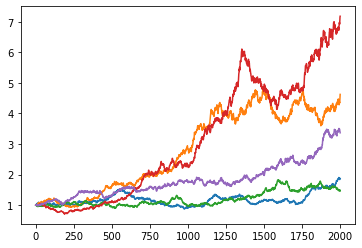

In [134]:
bm_montecarlo_returns.plot(legend=None)

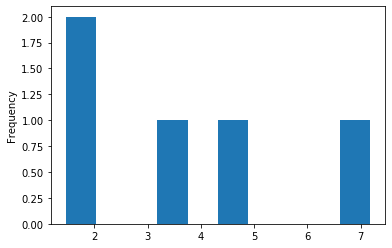

In [135]:
bm_cumulative_ret=bm_montecarlo_returns.iloc[-1, :]
bm_cumulative_ret.plot(kind='hist', bins=10)

## Define variables for Portfolio simulation

In [136]:
pf_means = {}
pf_std = {}
pf_last_day = {}

for stock in user_portfolio:
    pf_means[stock] = user_portfolio_returns.mean()[stock]
    pf_std[stock] = user_portfolio_returns.std()[stock]
    pf_last_day[stock] = user_portfolio_df[stock][-1]
#TODO Create a table to display this information for the user
(1+pf_means['AMZN'])**252
pf_means['AMZN']*252

0.3487227611655365

In [137]:
# Initialize empty DataFrame to hold simulated prices for each simulation
pf_montecarlo_returns = pd.DataFrame()

# Run the simulation of projecting stock prices
for n in range(number_simulations):
    simulated_portfolio_prices = {stock:[pf_last_day[stock]] for stock in user_portfolio}
    for i in range(number_records):
        for stock in user_portfolio:
            simulated_stocks_price = simulated_portfolio_prices[stock][-1] * (1 + np.random.normal(pf_means[stock], pf_std[stock]))
            simulated_portfolio_prices[stock].append(simulated_stocks_price)
    simulated_prices_df = pd.DataFrame(simulated_portfolio_prices)
    simulated_daily_returns = simulated_prices_df.pct_change()
    simulated_daily_returns.dropna(inplace=True)
    portfolio_daily_returns = simulated_daily_returns.dot(p_weights)
    pf_montecarlo_returns[n] = (1+portfolio_daily_returns.fillna(0)).cumprod()
pf_montecarlo_returns

,0,1,2,3,4
1,0.996531,0.991924,0.991562,1.003962,1.000553
2,1.005416,0.982475,1.000725,0.998397,1.009929
3,1.010924,0.976594,1.000652,1.023998,1.004588
4,1.003680,0.976980,0.989224,1.023929,1.000204
5,1.004177,0.981855,0.990430,1.015565,0.995287
...,...,...,...,...,...
1996,5.657209,5.741861,8.363737,6.005972,3.767026
1997,5.673601,5.752975,8.403230,5.979489,3.894392
1998,5.643639,5.801880,8.435664,5.916261,3.892194
1999,5.658627,5.842712,8.477212,5.939461,3.864607


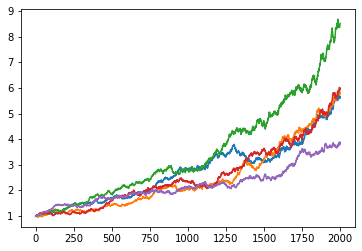

In [138]:
pf_montecarlo_returns.plot(legend=None)